# Estrategia 02
---

Esta estrategia tiene como objetivo el explorar la calidad de las features de **intensidad**, las cuales son ampliamente usadas en reconocimiento en imagenes de rayos-X.

---
## 1) Carga de Datos

In [167]:
import numpy as np
import os

# data directory path
DATADIR = 'data'

# carga de datos de training
x_training = np.load(os.path.join(DATADIR, 'training', 'dataset_features.npy'), allow_pickle=True)
label_training = np.load(os.path.join(DATADIR, 'training', 'dataset_labels.npy'), allow_pickle=True)
d_train = np.array([int(y[1:3]) for y in label_training])

# carga de datos de testing
x_testing = np.load(os.path.join(DATADIR, 'testing', 'dataset_features.npy'), allow_pickle=True)
label_testing = np.load(os.path.join(DATADIR, 'testing', 'dataset_labels.npy'), allow_pickle=True)
d_test = np.array([int(y[1:3]) for y in label_testing])

# features_label
flabels = np.load(os.path.join(DATADIR, 'flabels.npy'), allow_pickle=True)

### - Uso de caracteristicas:

Se van a usar las características asociadas a la **intensidad** de tonos de grises en cada imagen. En entre estás features están los momentos estadísticos de los valores en la escala y las features de *gabor*.

In [223]:
to_use = ['geo', 'des']  # esto es para hacer la comparación
to_use = ['int']

use_columns = []
for label in flabels:  # nombre de la feature
    for ftype in to_use:  # nombres de las features que queremos usar
        if ftype in label:
            use_columns.append(*np.where(flabels == label)[0])  # agregamos el indice de la feature

print(f'Using only {len(use_columns)} features...')

# selecionamos solo esas columnas
x_train = x_training[:, use_columns]
x_test = x_testing[:, use_columns]

Using only 73 features...


## 2) Transformación y Selección de Características

- Para esta parte de la estrategia se hicieron 3 procesamientos de los datos:
    
    1. Cleaining
    2. Normalization (```minmax```)
    3. Selection (```sfs``` con ```40 features```)


### - Training:

In [224]:
# solo cambiar el nombre de la función los parámetros son los mismos
from modules.feature_selection import sequential_forward_selection as sfs
from sklearn.preprocessing import MinMaxScaler
from pybalu.feature_selection import clean

FEATURES = 40

# Training: Cleaning
sclean = clean(x_train, show=False)
x_train_clean = x_train[:, sclean]
print('After Cleaning   : ' + str(x_train_clean.shape[1]) + ' features.')

# Training: Normalization
scaler = MinMaxScaler()
scaler.fit(x_train_clean)
x_train_norm = scaler.transform(x_train_clean)
print('Normalized       : ' + str(x_train_norm.shape[1]) + ' features.')

# Training: Feature selection
selected = sfs(x_train_norm, d_train, n_features=FEATURES, method="fisher")
x_train_selected = x_train_norm[:, selected]
print('After Selection  : ' + str(x_train_selected.shape[1]) + ' features.')

After Cleaning   : 48 features.
Normalized       : 48 features.
After Selection  : 40 features.


### - Testing:

In [225]:
# Testing: Cleaning
x_test_clean = x_test[:, sclean]

# Testing: Normalization
x_test_norm = scaler.transform(x_test_clean)

# Testing: Feature selection
x_test_selected = x_test_norm[:, selected]

print('Testing ft: '+ str(x_test_selected.shape[1]) + ' from (' + str(x_test_selected.shape[0]) + ' samples)')

Testing ft: 40 from (1260 samples)


## 3) Classification:

Finalmente, la clasificación de cada patch se hizo con una clasificador ```KNN``` con ```n_neighbors=11```:

### - Clasificador individual:

Accuracy:  0.894


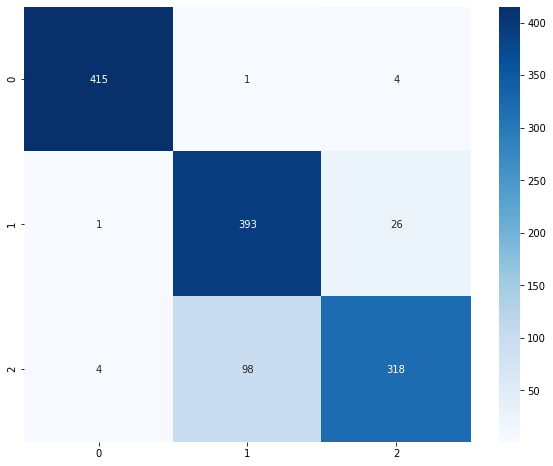

In [226]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns

K = 11

# Classification on Testing dataset
knn = KNeighborsClassifier(n_neighbors=K)
knn.fit(x_train_selected, d_train)

predicted = knn.predict(x_test_selected)

acc = accuracy_score(d_test, predicted)
print('Accuracy: ', round(acc, 3))

cmatrix = confusion_matrix(d_test, predicted)


fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cmatrix, cmap="Blues", annot=True, ax=ax, fmt='g')

### - Clasificador Grupal:

In [227]:
# contadores por clase y tipo de votos
votes = {'00': {}, '01': {}, '02': {}}
for i in range(label_testing.shape[0]):
    label = label_testing[i]
    # si aún no se agrega esta clase
    if not label[4:8] in votes[label[1:3]].keys():
        votes[label[1:3]][label[4:8]] = [predicted[i]]
    else:
        votes[label[1:3]][label[4:8]].append(predicted[i])

In [228]:
# hacemos la clasificación en grupos vamos a contruir un predict and true value
group_predicted = []
group_true_value = []
for cnumber in votes:
    for gnumber in votes[cnumber]:
        group_true_value.append(int(cnumber))
        predicted_list = votes[cnumber][gnumber]
        group_predicted.append(max(set(predicted_list), key=predicted_list.count))
g_predicted = np.array(group_predicted)
g_test = np.array(group_true_value)

Accuracy:  0.921


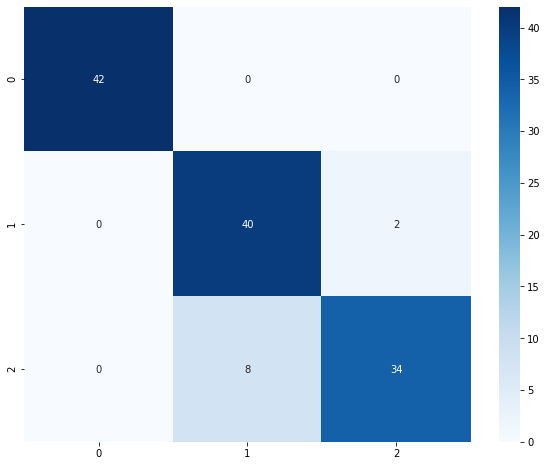

In [229]:
# estadisticas por grupos
g_acc = accuracy_score(g_test, g_predicted)
print('Accuracy: ', round(g_acc, 3))

g_cmatrix = confusion_matrix(g_test, g_predicted)

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(g_cmatrix, cmap="Blues", annot=True, ax=ax, fmt='g')